<a href="https://colab.research.google.com/github/Nickqq627/7112029017/blob/main/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 使用Python建立ARIMA模型，預測股票價格，並進行可視化。

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

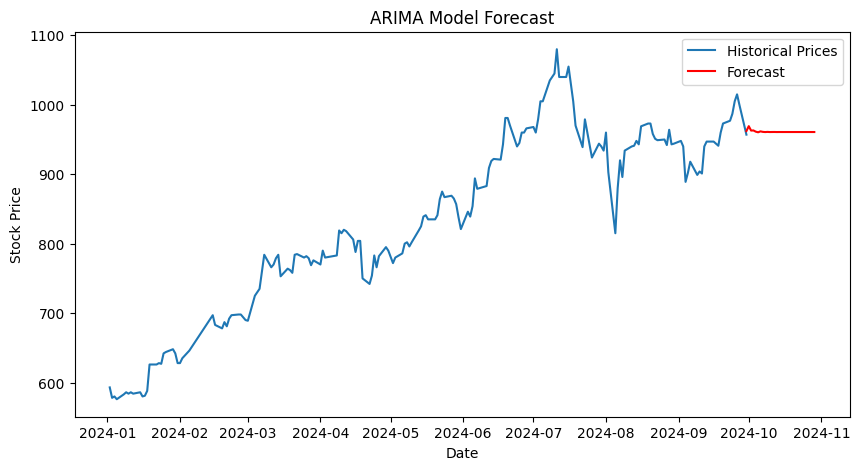

In [47]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import pandas as pd

# 下載台積電股價數據
def get_stock_data():
    ticker = "2330.TW"
    data = yf.download(ticker, start="2024-01-01", end="2024-10-01")
    return data

%matplotlib inline

# 取得數據
data = get_stock_data()

# 只使用 'Close' 收盤價
stock_prices = data['Close']

# 建立 ARIMA 模型，(p, d, q) 參數可以進行調整
model = ARIMA(stock_prices, order=(5, 1, 0))  # p=5, d=1, q=0
model_fit = model.fit()

# 預測未來 30 天的股價
forecast = model_fit.forecast(steps=30)

# 畫出預測結果
plt.figure(figsize=(10, 5))
plt.plot(stock_prices,  label='Historical Prices')
plt.plot(pd.date_range(stock_prices.index[-1], periods=30, freq='D'), forecast, label="Forecast", color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## 2. 使用Python設計一個量化交易策略，並使用歷史資料進行回測。

# ARIMA 模型

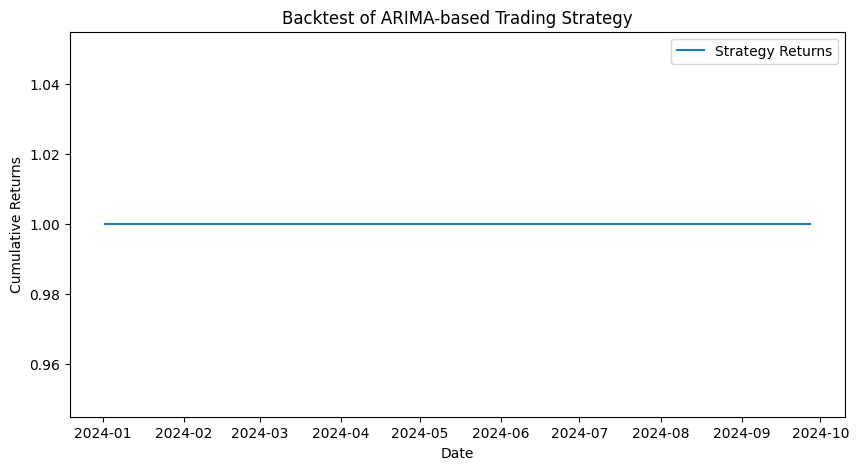

In [48]:
import numpy as np

# 設計簡單的量化交易策略
def backtest_strategy(data, forecast):
    stock_prices = data['Close']

    # 建立空的 signal 列表（1: 買入, -1: 賣出, 0: 持有）
    signals = np.zeros(len(stock_prices) + len(forecast))

    # 當 ARIMA 模型預測未來價格大於當前價格時，發出買入信號
    last_price = stock_prices.iloc[-1]
    for i in range(len(forecast)):
        if forecast.iloc[i] > last_price:  # 比較預測與最後的歷史價格
            signals[len(stock_prices) + i] = 1  # 買入
        else:
            signals[len(stock_prices) + i] = -1  # 賣出

    # 計算回測的收益
    returns = stock_prices.pct_change().shift(-1).dropna()  # 計算回報並移除 NaN
    returns = returns[:len(signals[:-1])]  # 確保收益的長度匹配
    strategy_returns = returns * signals[:-1][:len(returns)]  # 依據信號計算收益

    # 可視化策略收益
    plt.figure(figsize=(10, 5))
    plt.plot((1 + strategy_returns).cumprod(), label='Strategy Returns')
    plt.title('Backtest of ARIMA-based Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

# 進行回測
backtest_strategy(data, forecast)

# 馬可夫決策過程

[*********************100%***********************]  1 of 1 completed
<ipython-input-53-390fcb8d1dbe>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transition_matrix = pd.DataFrame(index=['up', 'down', 'flat'], columns=['up', 'down', 'flat']).fillna(0)


Initial Portfolio Value: 10000
Final Portfolio Value: 16458.36
Total Return: 64.58%


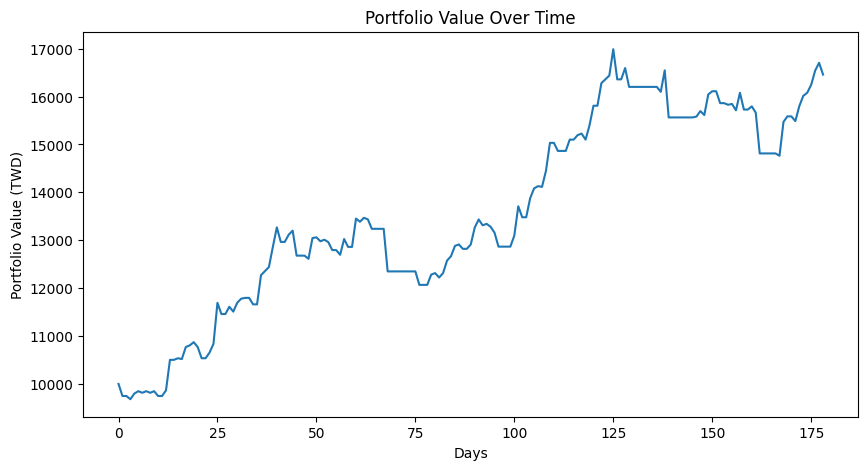

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 下載台積電數據
def get_stock_data():
    ticker = "2330.TW"
    data = yf.download(ticker, start="2024-01-01", end="2024-10-01")
    return data

data = get_stock_data()
data['Return'] = data['Adj Close'].pct_change()  # 計算日回報

# 定義狀態
def define_state(row):
    if row['Return'] > 0.01:  # 上漲
        return 'up'
    elif row['Return'] < -0.01:  # 下跌
        return 'down'
    else:  # 持平
        return 'flat'

data['State'] = data.apply(define_state, axis=1)

# 計算狀態轉移概率
transition_matrix = pd.DataFrame(index=['up', 'down', 'flat'], columns=['up', 'down', 'flat']).fillna(0)

for (i, j) in zip(data['State'], data['State'].shift(-1)):
    if j is not None:
        transition_matrix.loc[i, j] += 1

# 正規化轉移概率
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

# 定義行動和回報
def take_action(state):
    if state == 'up':
        return 'hold'
    elif state == 'down':
        return 'sell'
    else:
        return 'buy'

# 回測策略
initial_cash = 10000
cash = initial_cash
stock = 0
portfolio_value = []

for i in range(len(data) - 1):  # 不考慮最後一行
    current_state = data['State'].iloc[i]
    action = take_action(current_state)
    current_price = data['Adj Close'].iloc[i]

    # 根據行動進行買賣
    if action == 'buy' and cash > 0:
        stock = cash / current_price  # 用所有資金買入
        cash = 0  # 現金為零
    elif action == 'sell' and stock > 0:
        cash = stock * current_price  # 賣出所有股票
        stock = 0  # 股票數量為零

    # 計算當前資產總值
    total_value = cash + stock * current_price
    portfolio_value.append(total_value)

# 最後一天的資產總值
final_portfolio_value = portfolio_value[-1]

# 打印回測結果
print(f"Initial Portfolio Value: {initial_cash}")
print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
print(f"Total Return: {(final_portfolio_value - initial_cash) / initial_cash * 100:.2f}%")

# 可視化回測過程中的資產變化
plt.figure(figsize=(10, 5))
plt.plot(portfolio_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (TWD)')
plt.show()

# SVM

[*********************100%***********************]  1 of 1 completed


              precision    recall  f1-score   support

           0       0.30      0.25      0.27        12
           1       0.47      0.53      0.50        15

    accuracy                           0.41        27
   macro avg       0.39      0.39      0.39        27
weighted avg       0.39      0.41      0.40        27

Initial Portfolio Value: 10000
Final Portfolio Value: 12449.73
Total Return: 24.50%


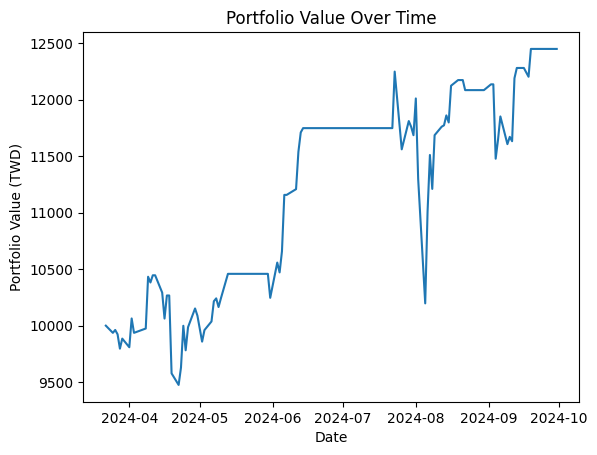

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 下載台積電數據
def get_stock_data():
    ticker = "2330.TW"
    data = yf.download(ticker, start="2024-01-01", end="2024-10-01")
    return data

data = get_stock_data()

# 計算技術指標作為特徵
data['SMA_10'] = data['Adj Close'].rolling(window=10).mean()
data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
data['RSI'] = (100 - (100 / (1 + data['Adj Close'].diff(1).apply(lambda x: max(x, 0)).rolling(window=14).mean() /
                        data['Adj Close'].diff(1).apply(lambda x: abs(x)).rolling(window=14).mean())))

# 刪除NaN值
data.dropna(inplace=True)

# 設置特徵與標籤
X = data[['SMA_10', 'SMA_50', 'RSI']]
# 標籤：若明天的價格比今天高，則標記為1，否則為0
data['Price_Up'] = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)
y = data['Price_Up']

# 分割資料為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化數據
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 訓練SVM模型
model = svm.SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

# 在測試集上預測
y_pred = model.predict(X_test_scaled)

# 顯示預測結果報告
print(classification_report(y_test, y_pred))

# =================================
# 基於 SVM 預測結果進行回測
# =================================

# 使用整個數據集來預測，準備進行回測
data['Predicted_Up'] = model.predict(scaler.transform(X))  # 對整個數據集進行預測

# 初始化回測參數
initial_cash = 10000  # 初始資金
cash = initial_cash    # 可用資金
stock = 0             # 持有股票數量
portfolio_value = []   # 用於存儲每一天的資產總值

# 回測
for i in range(1, len(data)):
    # 當前價格
    current_price = data['Adj Close'].iloc[i]

    # 模型預測的價格走勢
    prediction = data['Predicted_Up'].iloc[i]

    # 如果預測價格將上漲，且手中有現金，則買入股票
    if prediction == 1 and cash > 0:
        stock = cash / current_price  # 用所有資金買入股票
        cash = 0  # 買完後現金為0

    # 如果預測價格將下跌，且手中有股票，則賣出股票
    elif prediction == 0 and stock > 0:
        cash = stock * current_price  # 賣出所有股票，換回現金
        stock = 0  # 賣出後股票數量為0

    # 計算當前的資產總值（現金 + 股票價值）
    total_value = cash + stock * current_price
    portfolio_value.append(total_value)

# 最後一天的資產總值
final_portfolio_value = portfolio_value[-1]

# 打印回測結果
print(f"Initial Portfolio Value: {initial_cash}")
print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
print(f"Total Return: {(final_portfolio_value - initial_cash) / initial_cash * 100:.2f}%")

# 可視化回測過程中的資產變化
import matplotlib.pyplot as plt

plt.plot(data.index[1:], portfolio_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (TWD)')
plt.show()